# Lecture 7 - Student Notebook

In this exercises, you will create and interpret learning curves and compare the performance of different knowledge tracing models. We will use the same ASSISTments data set as for lecture 6.

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

We first load the data set.

In [1]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score

# PyBKT package imports
from pyBKT.models import Model
# Import the lmm model class
from pymer4.models import Lmer

DATA_DIR = "./../../data/"

In [2]:
assistments = pd.read_csv(DATA_DIR + 'assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [3]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


We also implement a utility function that splits the data in two folds, making sure that all interactions of a student land in the same fold. We will use this function to obtain train, test, and validation folds of our data.

In [4]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

## BKT Models - Learning Curves
Last week, we have seen how to use BKT to predict the probability that a student will solve a task correctly.
In addition, we can also use this type of model to compute learning curves and in this way analyze the learning activity (in our case the skills). 

We first fit a BKT model with all default parameters, i.e., Model(seed=0) in pyBKT, on the full data data set (no split into train and test set needed as we are not assessing predictive performance of the model here, but just checking interpretation). To keep things simpler on the following 6 skills for this exercise:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

In [5]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']

data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Division Fractions', 'Circle Graph', 'Venn Diagram', 'Area Rectangle', 'Finding Percents', 'Mode'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


In [6]:
# Initialize the model
model = Model(seed=0)

# Fit the model on the entire dataset
%time model.fit(data=data)

predictions = model.predict(data=data)[['user_id', 'skill_name', 'correct', 'correct_predictions']]

# Rename the dataframe columns as per instructions
predictions.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']

CPU times: user 6.49 s, sys: 1.02 ms, total: 6.49 s
Wall time: 3.32 s


In [7]:
predictions.head()

,user_id,skill_name,y_true,y_pred_bkt
3957,14,Circle Graph,0,0.45897
3958,14,Circle Graph,1,0.33319
3959,14,Circle Graph,0,0.56200
3960,14,Circle Graph,0,0.43364
3961,14,Circle Graph,0,0.31410


Next, we create a function that computes the learning curve (observed or predicted) for us by averaging over the success rate of all users at a given opportunity.

In [8]:
def avg_y_by_x(x, y):
    '''
    Compute average learning curve and number of students over the number of opportunities. 
    x is the number of opportunities.
    y the success rates of the users (can be predicted success rate or true success rate).
    '''
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

Then, we create a function for plotting learning curve and a bar chart with the number of students per opportunity for a given skill.

In [9]:
def plot_learning_curve(skill_name):
    '''
    Plot learning curve using BKT model for skill `skill_name`. 
    '''
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_bkt columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_bkt columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_bkt columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    return plt

We then plot the learning curve and number of opportunities per student for skill `Circle Graph`.

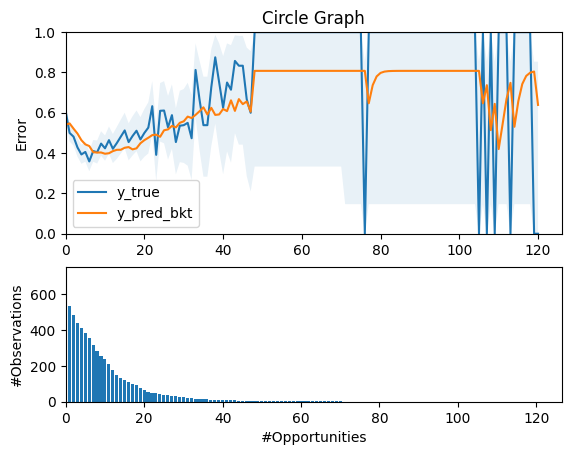

In [10]:
plt = plot_learning_curve('Circle Graph')
plt.show()

### Your Turn 1 - Learning Curves

Visualize and interpret the learning curves and number of students per opportunity for two selected skills. You can choose from the remaining five skills: `'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`. Send us your visualizations as well as the discussion.

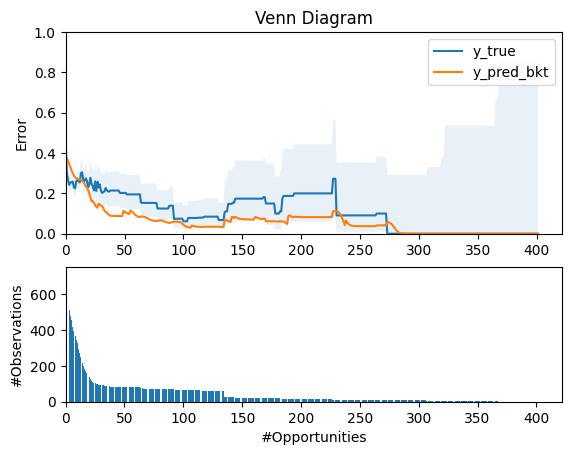

In [14]:
# YOUR TURN: Visualize the learning curve for the first skill.

first_skill_name = "Venn Diagram" # replace the skill name with one of the 5 skills above
plt = plot_learning_curve(first_skill_name)

### Share the plot with us
#send(plt, 1)
plt.show()

In [ ]:
# YOUR TURN: What is your analysis about the learning curve for the first skill?

### Share your analysis of the learning curve with us
first_skill_interpretation = "Write your interpretation here"
send(first_skill_interpretation, 4)

Variable npt_config is not defined


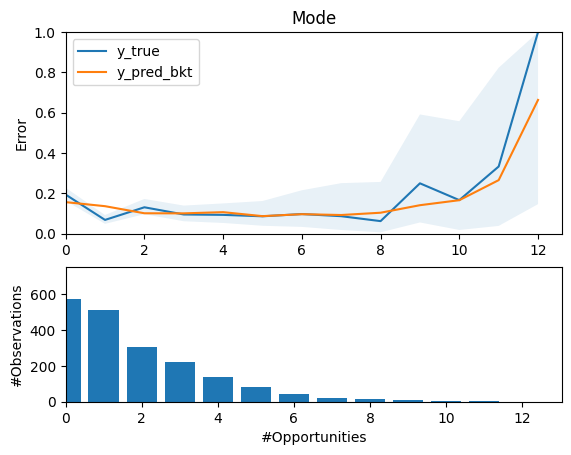

In [15]:
# YOUR TURN: Visualize the learning curve for the second skill.

second_skill_name = "Mode" # replace the skill name with one of the 5 skills above
plt = plot_learning_curve(second_skill_name)

### Share the plot with us
send(plt, 2)
plt.show()

In [ ]:
# YOUR TURN: What is your analysis about the learning curve for the second skill?

### Share your analysis of the learning curve with us
second_skill_interpretation = "Write your interpretation here"
send(second_skill_interpretation, 6)

## Additive Factors Model (AFM) and Performance Factors Analysis (PFA)

The AFM and PFA models are both based on logistic regression and item response theory (IRT). Specifically, they compute the probability that a student will solve a task correctly based on the number of previous attempts the student had at the corresponding skill (in case of AFM) and based on the correct and wrong attempts at the corresponding skill (in case of PFA), respectively. We therefore first preprocess the data to compute these variables.

In [16]:
# Data processing
# Number of attempts before current
def preprocess_data(data):
    data.loc[:, 'aux'] = 1
    data.loc[:, 'prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['aux'].cumsum() -1

    # Number of correct and incorrect attempts before current attempt
    data.loc[:, 'correct_aux'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['correct'].cumsum()
    data.loc[:, 'before_correct_num'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['correct_aux'].shift(periods=1, fill_value=0)
    data.loc[:, 'before_wrong_num'] = data['prev_attempts'] - data['before_correct_num']
    return data

data = preprocess_data(data)
data.head()

,user_id,order_id,skill_name,correct,correct_predictions,state_predictions,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
3957,14,21617623,Circle Graph,0,0.45897,0.55462,1,0,0,0,0
3958,14,21617632,Circle Graph,1,0.33319,0.33498,1,1,1,0,1
3959,14,21617641,Circle Graph,0,0.56200,0.73454,1,2,1,1,1
3960,14,21617650,Circle Graph,0,0.43364,0.51039,1,3,1,1,2
3961,14,21617659,Circle Graph,0,0.31410,0.30164,1,4,1,1,3


Next, we split the data into a training and a test data set.

In [17]:
# Obtain indexes
train_index, test_index = next(create_iterator(data))
# Split the data
X_train, X_test = data.iloc[train_index], data.iloc[test_index]

Next, we fit an AFM model to the training data and predict on the test data. Note that the implementation below only works for a one-to-one correspondance of task and skill, i.e. when a task is associated to exactly one skill. In case of a data set containing tasks with multiple skills, we would need to use the [pyAFM](https://github.com/cmaclell/pyAFM) package. A tutorial on using pyAFM can be found [here](https://github.com/epfl-ml4ed/mlbd-2021/tree/main/Tutorials/Tutorial06/Tutorial06).

In [18]:
# Initialize and fit the model
model = Lmer("correct ~ (1|user_id) + (1|skill_name) + (0 + prev_attempts|skill_name)", data=X_train, family='binomial')
%time model.fit() 
# Compute predictions
X_test['afm_predictions'] = model.predict(data=X_test, verify_predictions=False)
X_test.head()

Formula: correct~(1|user_id)+(1|skill_name)+(0+prev_attempts|skill_name)

Family: binomial	 Inference: parametric

Number of observations: 40258	 Groups: {'user_id': 1221.0, 'skill_name': 6.0}

Log-likelihood: -16797.782 	 AIC: 33603.565

Random effects:

                       Name     Var     Std
user_id         (Intercept) 2.56000 1.60000
skill_name      (Intercept) 0.68300 0.82700
skill_name.1  prev_attempts 0.00500 0.06900

No random effect correlations specified

Fixed effects:

CPU times: user 29.7 s, sys: 261 ms, total: 29.9 s
Wall time: 30 s


,user_id,order_id,skill_name,correct,correct_predictions,state_predictions,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num,afm_predictions
53382,53167,26451283,Mode,1,0.84330,0.89625,1,0,1,0,0,0.85507
53383,53167,26451302,Mode,1,0.92807,0.99413,1,1,2,1,0,0.86928
157253,53167,32517498,Division Fractions,0,0.59832,0.68806,1,0,0,0,0,0.62272
157254,53167,32517627,Division Fractions,1,0.43335,0.45102,1,1,1,0,1,0.64312
157255,53167,32517648,Division Fractions,1,0.73088,0.87852,1,2,2,1,1,0.66302


Next, we fit a PFA model to the data. Again, this implementation works for one-to-one correspondance and tasks with multiple skills would require the use of [pyAFM](https://github.com/cmaclell/pyAFM).

In [19]:
# Initialize and fit the model
model = Lmer("correct ~ (1|user_id) + (1|skill_name) + (0 + before_correct_num|skill_name) + (0 + before_wrong_num|skill_name)", data=X_train, family='binomial')
%time model.fit()
# Compute predictions
X_test['pfa_predictions'] = model.predict(data=X_test, verify_predictions=False)
X_test.head()

Formula: correct~(1|user_id)+(1|skill_name)+(0+before_correct_num|skill_name)+(0+before_wrong_num|skill_name)

Family: binomial	 Inference: parametric

Number of observations: 40258	 Groups: {'user_id': 1221.0, 'skill_name': 6.0}

Log-likelihood: -16385.969 	 AIC: 32781.939

Random effects:

                            Name     Var     Std
user_id              (Intercept) 1.74800 1.32200
skill_name           (Intercept) 0.69900 0.83600
skill_name.1  before_correct_num 0.02600 0.16200
skill_name.2    before_wrong_num 0.00000 0.01000

No random effect correlations specified

Fixed effects:

CPU times: user 1min 12s, sys: 375 ms, total: 1min 12s
Wall time: 1min 27s


,user_id,order_id,skill_name,correct,correct_predictions,state_predictions,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num,afm_predictions,pfa_predictions
53382,53167,26451283,Mode,1,0.84330,0.89625,1,0,1,0,0,0.85507,0.83721
53383,53167,26451302,Mode,1,0.92807,0.99413,1,1,2,1,0,0.86928,0.87290
157253,53167,32517498,Division Fractions,0,0.59832,0.68806,1,0,0,0,0,0.62272,0.61971
157254,53167,32517627,Division Fractions,1,0.43335,0.45102,1,1,1,0,1,0.64312,0.62047
157255,53167,32517648,Division Fractions,1,0.73088,0.87852,1,2,2,1,1,0.66302,0.65994


## BKT

We first also fit a BKT model to this data set using the same train/test split as above.

In [20]:
df_preds = pd.DataFrame()

# Train a BKT model for each skill
for skill in skills_subset:
    print("--{}--".format(skill))
    X_train_skill = X_train[X_train['skill_name'] == skill]
    X_test_skill = X_test[X_test['skill_name'] == skill]
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train_skill) 
    preds = model.predict(data=X_test_skill) [['user_id', 'order_id', 'skill_name', 'correct', 'prev_attempts',
       'before_correct_num', 'before_wrong_num', 'afm_predictions', 'pfa_predictions', 'correct_predictions']]
    df_preds = df_preds.append(preds)

X_test = df_preds
X_test.columns = ['user_id', 'order_id', 'skill_name', 'correct', 'prev_attempts',
       'before_correct_num', 'before_wrong_num', 'afm_predictions', 'pfa_predictions', 'bkt_predictions']
X_test.head()

--Circle Graph--
CPU times: user 2.97 s, sys: 13.2 ms, total: 2.98 s
Wall time: 1.45 s
--Venn Diagram--


/tmp/ipykernel_520/1614788260.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


CPU times: user 1.3 s, sys: 857 µs, total: 1.3 s
Wall time: 603 ms
--Mode--


/tmp/ipykernel_520/1614788260.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 290 ms
--Division Fractions--


/tmp/ipykernel_520/1614788260.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


CPU times: user 763 ms, sys: 6.22 ms, total: 770 ms
Wall time: 382 ms
--Finding Percents--


/tmp/ipykernel_520/1614788260.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


CPU times: user 582 ms, sys: 0 ns, total: 582 ms
Wall time: 289 ms
--Area Rectangle--


/tmp/ipykernel_520/1614788260.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


CPU times: user 492 ms, sys: 0 ns, total: 492 ms
Wall time: 205 ms


/tmp/ipykernel_520/1614788260.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


,user_id,order_id,skill_name,correct,prev_attempts,before_correct_num,before_wrong_num,afm_predictions,pfa_predictions,bkt_predictions
3969,64525,28186893,Circle Graph,1,0,0,0,0.48266,0.46224,0.45193
3970,64525,28187093,Circle Graph,1,1,1,0,0.49251,0.48999,0.63194
3971,64525,32413158,Circle Graph,1,2,2,0,0.50236,0.51780,0.68854
3972,64525,33022751,Circle Graph,0,3,3,0,0.51221,0.54551,0.70022
3973,64525,33023039,Circle Graph,1,4,3,1,0.52205,0.54598,0.69561


In [21]:
X_test.to_csv('x_test_07.csv.gz', compression = 'gzip', index = False)

# Your Turn 2 - Model Comparison on Subset

Up to now, we have compared model performance on a subset of the data. Your task is to compare and discuss performance of the different models:
1. Visualize the overall RMSE and AUC of the four models (AFM, PFA, BKT) such that the metrics can be easily compared.
2. Interpret your results and discuss your observations.

In [22]:
# If it is taking too long to run, you may load our X_test to compute the RMSE and AUC
X_test = pd.read_csv('x_test_07.csv.gz', compression = 'gzip')

In [25]:
X_test["skill_name"].unique()

array(['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions',
       'Finding Percents', 'Area Rectangle'], dtype=object)

In [28]:
Circle_Graph = X_test[X_test["skill_name"]=="Circle Graph"]
Venn_Diagram = X_test[X_test["skill_name"]=="Venn Diagram"]
Mode = X_test[X_test["skill_name"]=="Mode"]
Division_Fractions = X_test[X_test["skill_name"]=="Division Fractions"]
Finding_Percents = X_test[X_test["skill_name"]=="Finding Percents"]
Area_Rectangle = X_test[X_test["skill_name"]=="Area Rectangle"]


In [32]:
from sklearn.metrics import mean_squared_error, roc_auc_score
RMSE, AUC = [], []
predictions_list = ["afm_predictions", "pfa_predictions", "bkt_predictions"]

for predictions in predictions_list:
    RMSE.append(mean_squared_error(X_test.correct, X_test[predictions], squared = False))
    AUC.append(roc_auc_score(X_test.correct, X_test[predictions]))

In [ ]:
# Visualize plots
#send(plt, 3)
plt.show()

In [ ]:
interpretation = "Write your interpretation here"

send(interpretation, 4)